In [1]:
#- Start off on a cloud day. 
#- Implement your weather forecast based on the above probabilities
#- Run your simulator for N days (with $N\gtrsim 10^4$)
#- Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
#- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
#- Use a summary statistics to determine the most likely value and an error on our estimate.
#- In the above example, experiment with chopping off different numbers of initial points as burn-in.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from astroML.stats import sigmaG

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 12

In [3]:
#Variables definition
N_days=100_000
burnin=5000 
initial_state=1
seed=7

In [4]:
# Simulation of a 2-state (Cloud=0, Clear=1) Markov chain of length N_days
def simulate_markov_weather(N_days=100_000, initial_state=0, seed=None):
    rng = np.random.default_rng(seed)
    weather = np.empty(N_days, dtype=int)
    weather[0] = initial_state

    for t in range(1, N_days):
        if weather[t-1] == 1:  # yesterday Clear
            weather[t] = rng.choice([0, 1], p=[0.1, 0.9])    #P(Clear|Clear)=0.9, P(Cloud|Clear)=0.1
        else:                  # yesterday Cloud
            weather[t] = rng.choice([0, 1], p=[0.5, 0.5])    #P(Clear|Cloud)=0.5, P(Cloud|Cloud)=0.5

    running_clear = np.cumsum(weather) / (np.arange(N_days) + 1.0)
    return weather, running_clear

weather, running_clear = simulate_markov_weather(N_days, initial_state, seed)


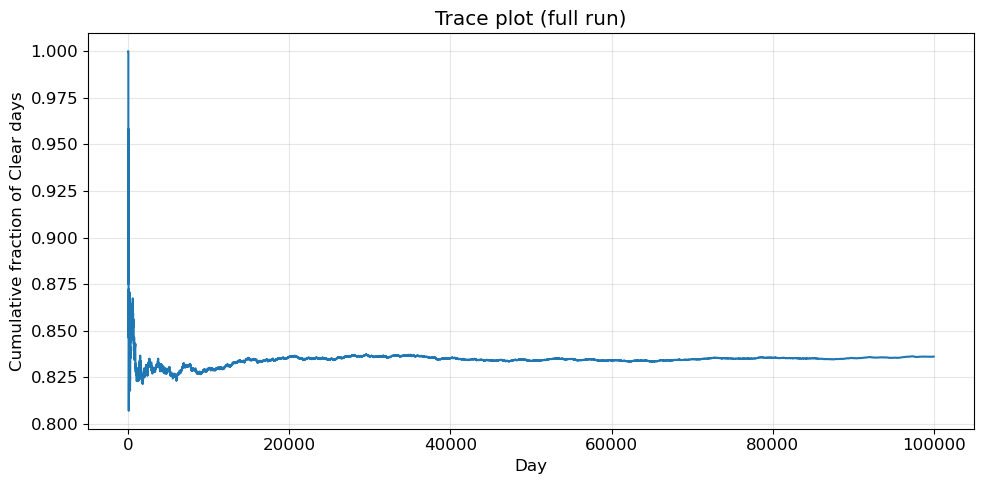

In [5]:
# Trace plot
def plot_trace(running_clear, title="Trace plot (running fraction of Clear)"):
    plt.figure(figsize=(10, 5))
    plt.plot(running_clear, lw=1.5, color='tab:blue')
    plt.xlabel("Day")
    plt.ylabel("Cumulative fraction of Clear days")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_trace(running_clear, title="Trace plot (full run)")


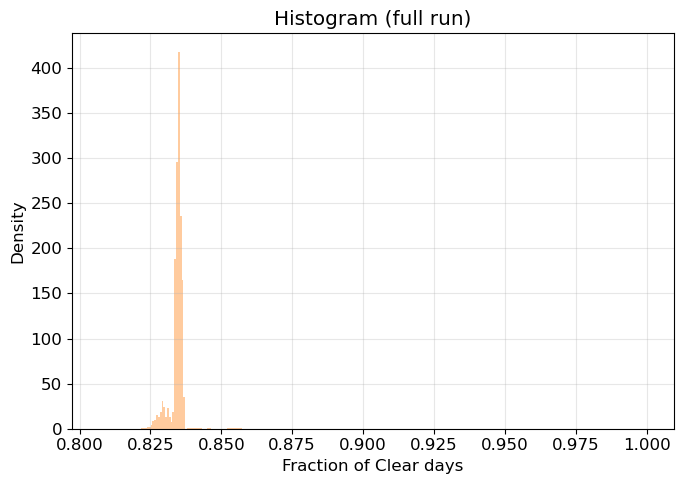

In [6]:
# Distribution of p(clear)
def plot_hist(running_clear, bins=300, title="Histogram of running fraction"):
    plt.figure(figsize=(7, 5))
    plt.hist(running_clear, bins=bins, density=True, alpha=0.4, color='tab:orange')
    plt.xlabel("Fraction of Clear days")
    plt.ylabel("Density")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_hist(running_clear, bins=300, title="Histogram (full run)")


In [7]:
# Summary statistics (median, sigmaG, min/max)
def print_summary(name, x):
    med = np.median(x)
    spread = sigmaG(x)
    xmin, xmax = np.min(x), np.max(x)
    print(f"{name}")
    print(f"  median  : {med:.6f}")
    print(f"  sigmaG  : {spread:.6f}")
    print(f"  min/max : {xmin:.6f} / {xmax:.6f}")

print_summary("Full run", running_clear)


Full run
  median  : 0.834820
  sigmaG  : 0.001042
  min/max : 0.807018 / 1.000000



Burn-in: ~5000 samples


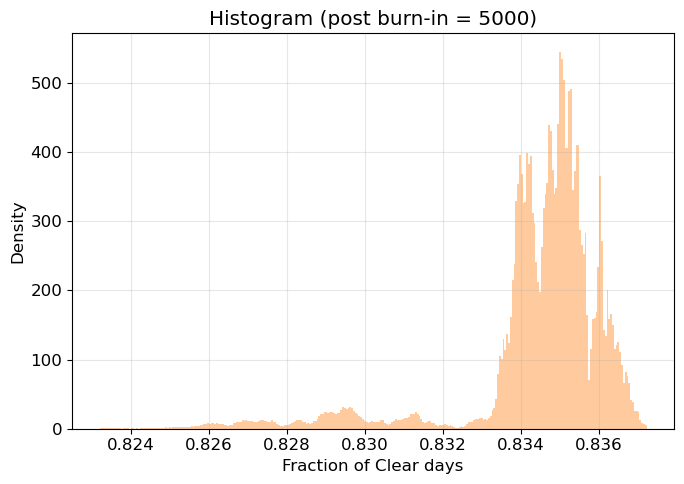

Post burn-in
  median  : 0.834870
  sigmaG  : 0.000986
  min/max : 0.823204 / 0.837235


In [8]:
# Burn-in 
print(f"\nBurn-in: ~{burnin} samples")
running_burn = running_clear[burnin:]
plot_hist(running_burn, bins=300, title=f"Histogram (post burn-in = {burnin})")
print_summary("Post burn-in", running_burn)

Running multiple chains: 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


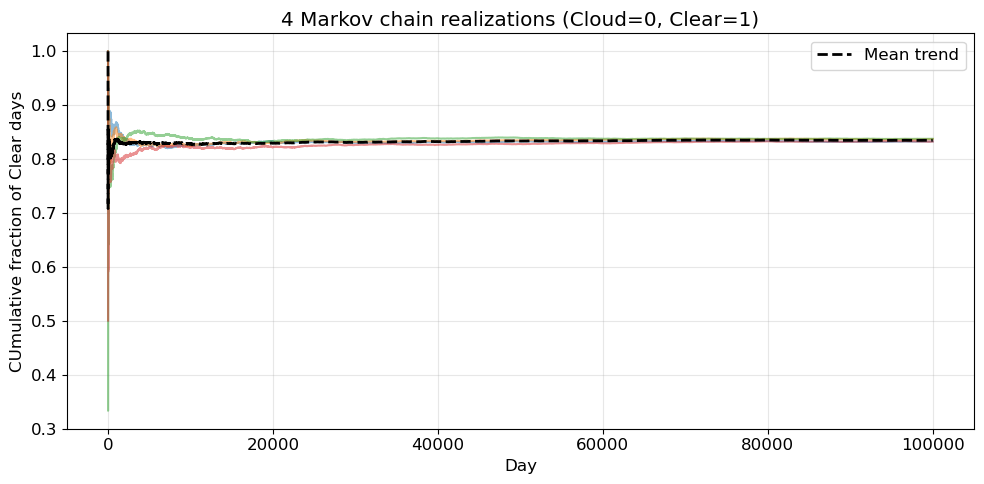

In [9]:
#Run several independent chains and plot their traces and mean trend.
def plot_multiple_realizations(N_days=100_000, n_realizations=4, initial_state=1, seed=None):
    rng = np.random.default_rng(seed)
    all_runs = []
    for _ in tqdm(range(n_realizations), desc="Running multiple chains"):
        # different seed per run for variability
        w, rc = simulate_markov_weather(N_days, initial_state, seed=rng.integers(0, 2**32-1))
        all_runs.append(rc)

    all_runs = np.array(all_runs)

    plt.figure(figsize=(10, 5))
    for r in all_runs:
        plt.plot(r, alpha=0.5)
    mean_trend = np.mean(all_runs, axis=0)
    plt.plot(mean_trend, color='black', linestyle='dashed', linewidth=2, label='Mean trend')
    plt.xlabel("Day")
    plt.ylabel("CUmulative fraction of Clear days")
    plt.title(f"{n_realizations} Markov chain realizations (Cloud=0, Clear=1)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_runs, mean_trend

runs, mean_trend = plot_multiple_realizations(N_days=min(100_000, N_days),
                                                n_realizations=4,
                                                initial_state=initial_state,
                                                seed=seed)
